In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../scripts")
import models
import rnn
import pickle
from Bio import SeqIO
import os
from main import load_data, generate_X

# Test the `RNNModel`

In [3]:
base_path = '/Users/venkatesh-sivaraman/Documents/School/MIT/6-047/proj/hicmotif/data/'

In [4]:
with open(os.path.join(base_path, 'epigenomic_tracks', 'GM12878.pickle'), 'rb') as file:
    id, data = pickle.load(file)

In [5]:
seq = None
for record in SeqIO.parse(os.path.join(base_path, 'loop_sequences_GM12878.fasta'), 'fasta'):
    print(record.id.replace('chr', ''), id)
    if record.id.replace('chr', '') != id: continue
    seq = models.Sequence(id, str(record.seq), data)
    break

print(len(seq.seq))

10:100225000:100425000 10:100225000:100425000
200000


In [6]:
seq_length = 100
num_examples = len(seq.seq) // seq_length
seq_array = seq.to_array()

# Generate num_examples subsequences of length seq_length with replacement
X = np.zeros((num_examples, seq_array.shape[0], seq_length))
for i in range(num_examples):
    start = np.random.randint(0, seq_array.shape[1] - seq_length)
    X[i] = seq_array[:,start:start + seq_length]

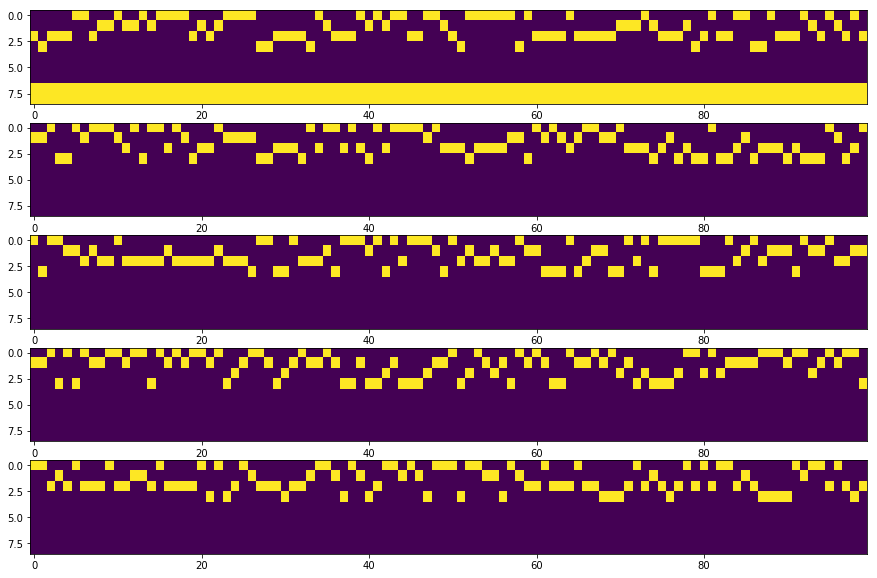

In [7]:
# Look at some of the training examples
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.imshow(X[i], aspect='auto')
plt.show()

In [8]:
#Generate random y
n_labels = 3
Y_numerical = np.random.randint(0, n_labels, size=X.shape[0])
Y = np.zeros((X.shape[0], n_labels))
for i in range(Y_numerical.shape[0]):
    Y[i,Y_numerical[i]] = 1

In [9]:
model = rnn.RNNModel(sequence_length=seq_length, n_features=X.shape[1], n_labels=n_labels)
model.create()

In [24]:
model.train(X, Y, epochs=25)

Epoch 1/25
2000/2000 [==============================] - 1s 526us/step - loss: 1.0977 - acc: 0.3440
Epoch 2/25
2000/2000 [==============================] - 1s 470us/step - loss: 1.0965 - acc: 0.3555
Epoch 3/25
2000/2000 [==============================] - 1s 479us/step - loss: 1.0945 - acc: 0.3680
Epoch 4/25
2000/2000 [==============================] - 1s 529us/step - loss: 1.0928 - acc: 0.3690
Epoch 5/25
2000/2000 [==============================] - 1s 479us/step - loss: 1.0756 - acc: 0.4100
Epoch 6/25
2000/2000 [==============================] - 1s 448us/step - loss: 1.0283 - acc: 0.4685
Epoch 7/25
2000/2000 [==============================] - 1s 514us/step - loss: 0.9450 - acc: 0.5400
Epoch 8/25
2000/2000 [==============================] - 1s 459us/step - loss: 0.8764 - acc: 0.5655
Epoch 9/25
2000/2000 [==============================] - 1s 521us/step - loss: 0.8037 - acc: 0.6130
Epoch 10/25
2000/2000 [==============================] - 1s 505us/step - loss: 0.7268 - acc: 0.6570
Epoch 11/

In [11]:
model.model

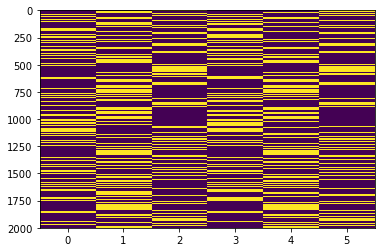

In [25]:
Y_pred = model.model.predict(X)
Y_pred = np.where(Y_pred == np.max(Y_pred, axis=1).reshape(-1, 1), 1, 0)
plt.imshow(np.hstack([Y, Y_pred]), aspect='auto')

## 12/7: Test the input to the new RNN model

In [8]:
def load_assigned_states(path, data, seq_length, spacing):
    """
    Loads pre-assigned state labels from a CSV file, associating the vectors with
    the appropriate interaction matrix.
    """
    X, ranges = generate_X(data, seq_length, spacing)
    range_mapping = {data[i][1].identifier: ranges[i] for i in range(len(data))}
    states = {}
    seen_ids = set()
    with open(path, 'r') as file:
        for line in file:
            comps = line.strip().split(',')
            id = comps.pop(0)
            if id not in range_mapping: continue
            start, stop = range_mapping[id]
            score = comps.pop(0)
            asg = np.array([int(float(c)) for c in comps])[seq_length // spacing:]
            assert asg.shape[0] >= stop - start, "incorrect length: {} vs {}-{} ({})".format(asg.shape[0], start, stop, stop - start)
            states[id] = asg[:stop - start]
            seen_ids.add(id)

    assert len(seen_ids) == len(range_mapping), "missing identifiers: " + str(set(range_mapping.keys()) - seen_ids)
    return states

In [5]:
pid = 38591
n_labels = 8
data = load_data(base_path + "GM12878_10k", base_path + "loop_sequences_GM12878.fasta", base_path + "epigenomic_tracks/GM12878.pickle")
seq_length = 100
spacing = 50# if test else 10
batch_size = 10

# Random batch of data for each epoch
indexes = np.random.choice(len(data), size=(batch_size,), replace=False)
batch = [data[i] for i in indexes]

Reading histone data...
Reading sequence data...
Reading Hi-C data...
Loaded 4280 items - 17 had missing data.


TypeError: load_assigned_states() takes 4 positional arguments but 5 were given

In [9]:
state_map = load_assigned_states(base_path + "dp_assignments/assignments_{}.csv".format(pid), batch, seq_length, spacing)

In [23]:
with open("../data/R_values.txt", "r") as file:
    Rs = eval(file.read(), {"array": np.array})
len(Rs)

12

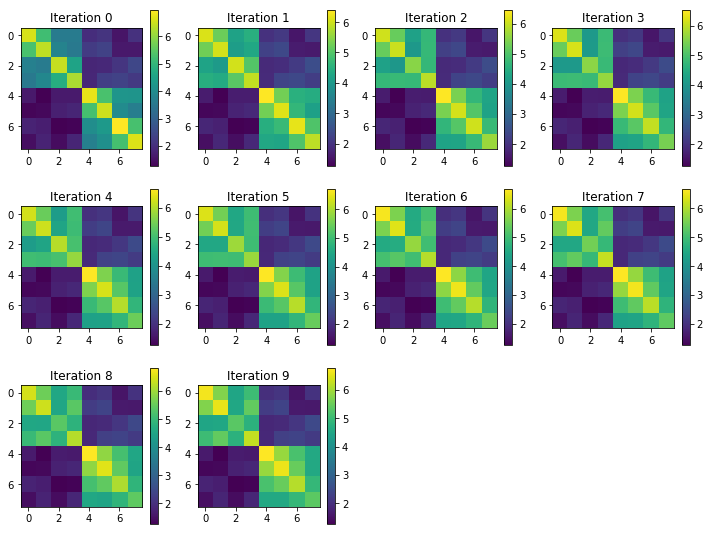

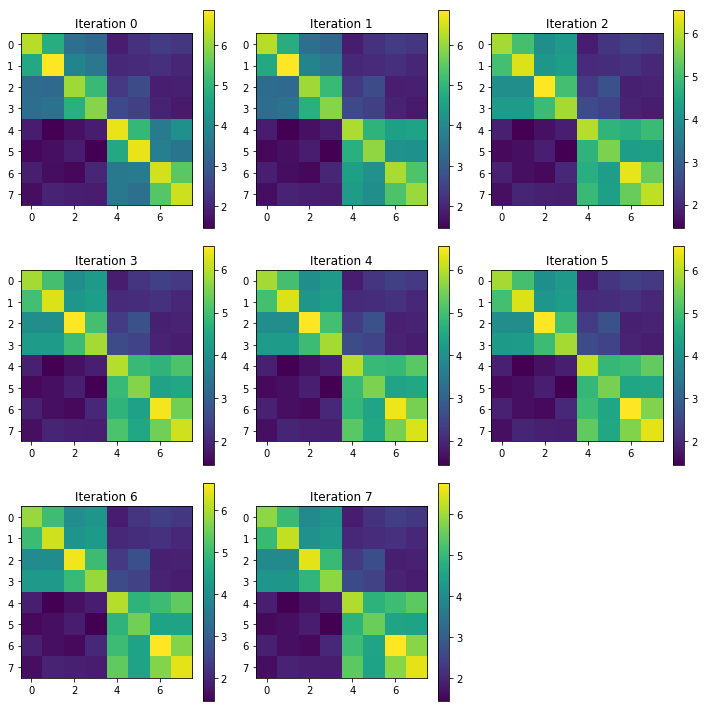

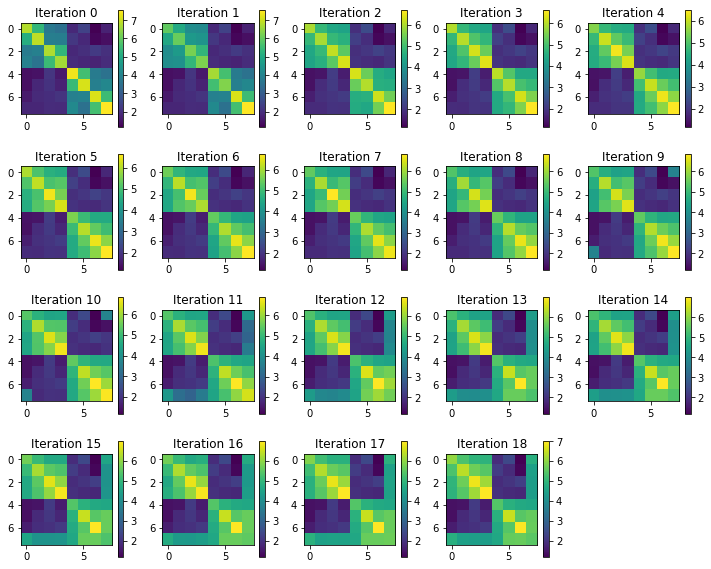

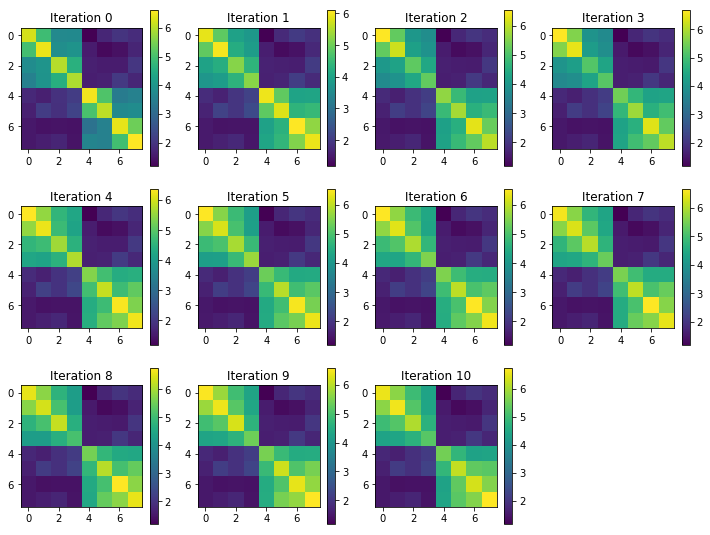

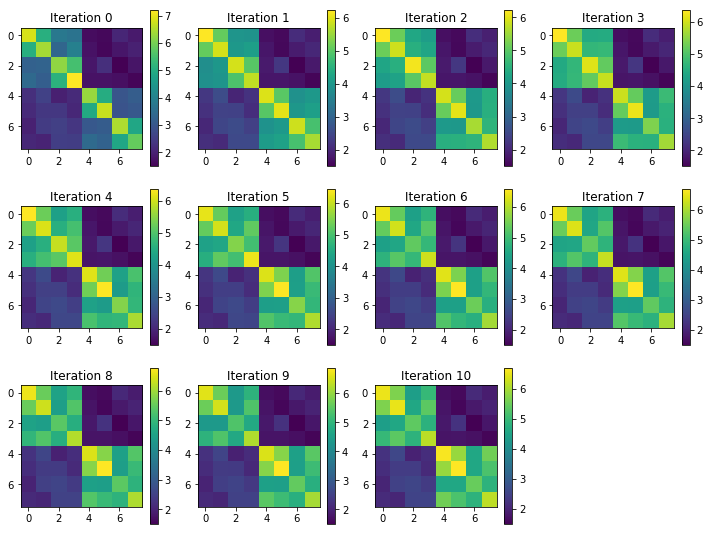

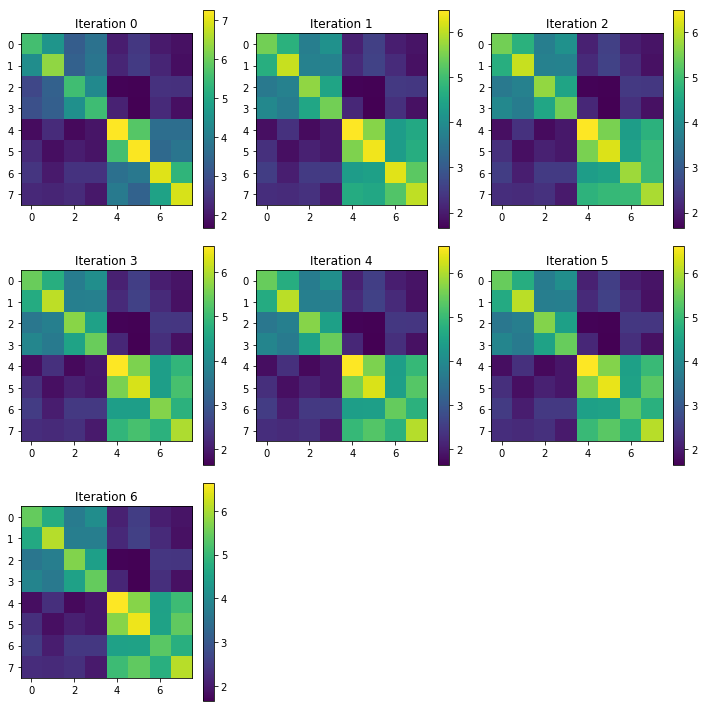

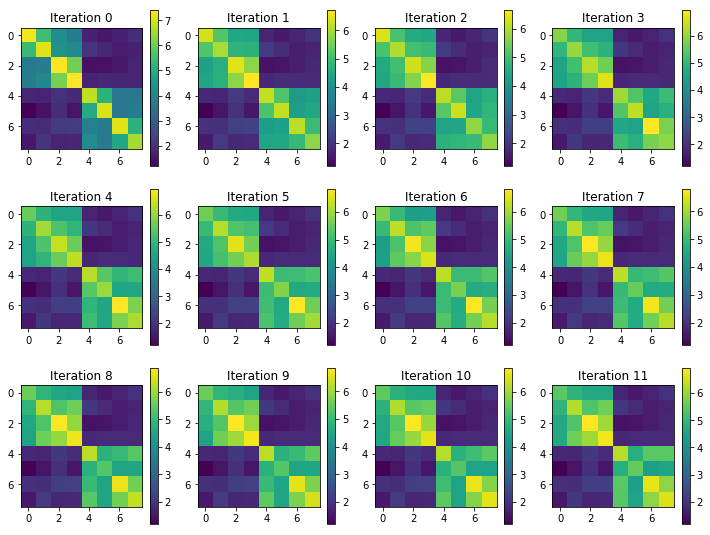

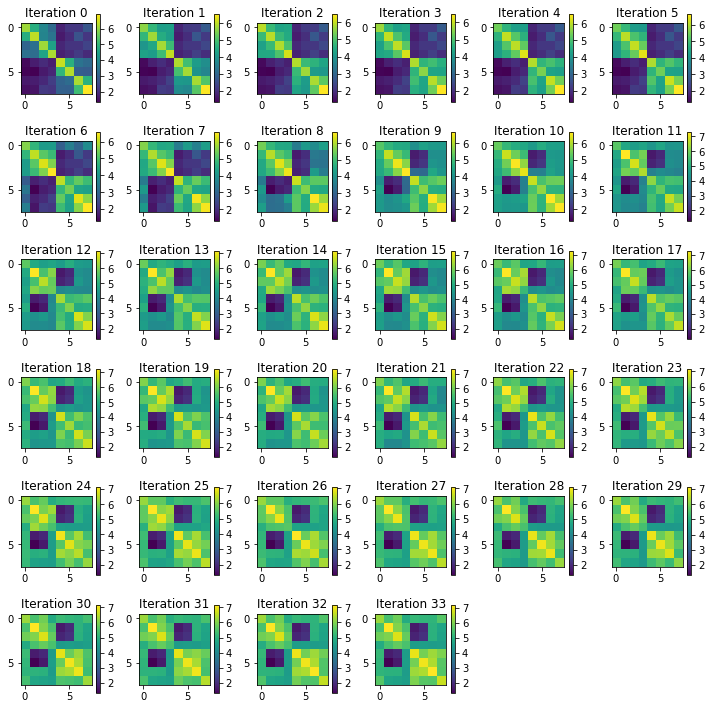

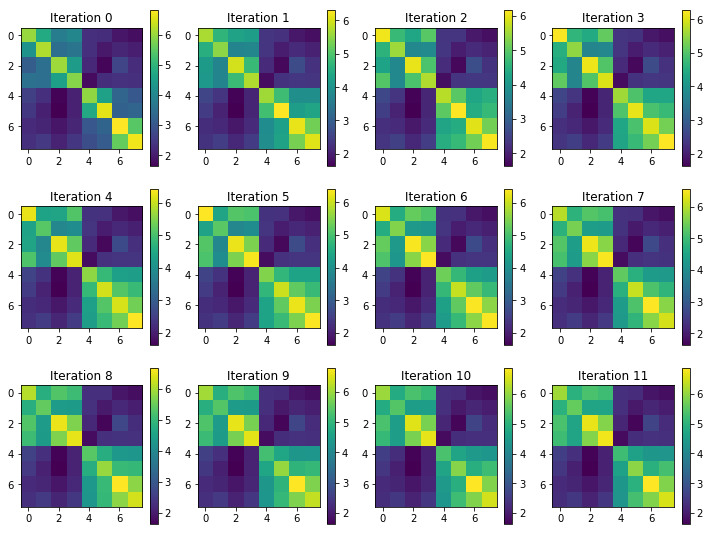

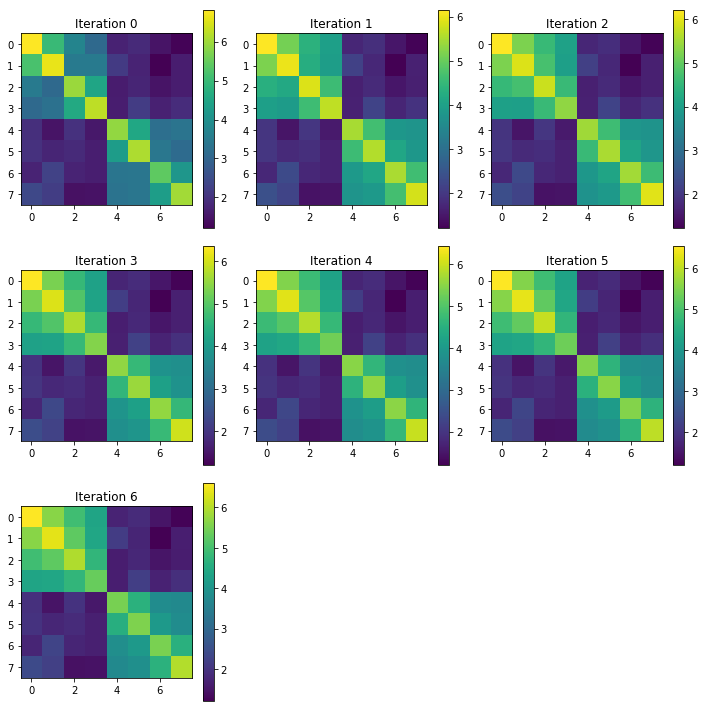

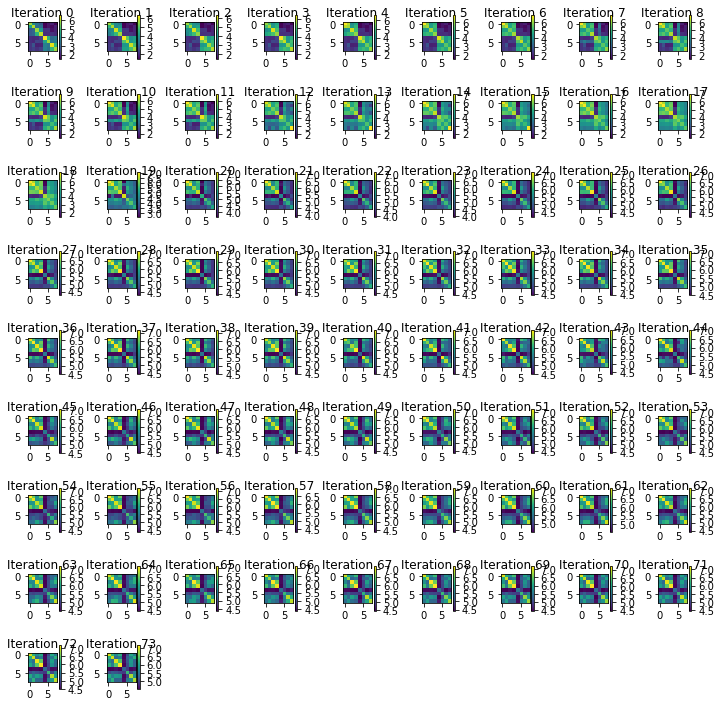

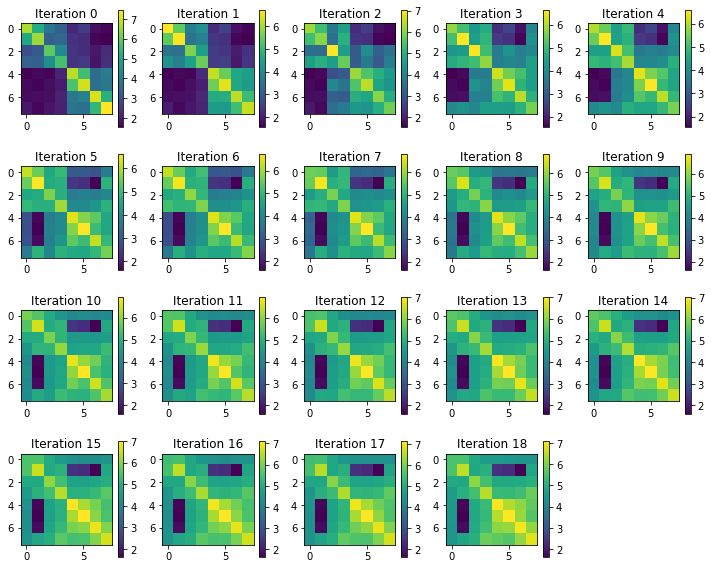

In [31]:
for j in range(len(Rs)):
    plt.figure(figsize=(10, 10))
    dim = np.ceil(np.sqrt(len(Rs[j])))
    for i, R in enumerate(Rs[j]):
        plt.subplot(dim, dim, i + 1)
        plt.imshow(R)
        plt.colorbar()
        plt.title("Iteration " + str(i))
    plt.tight_layout()
    plt.show()

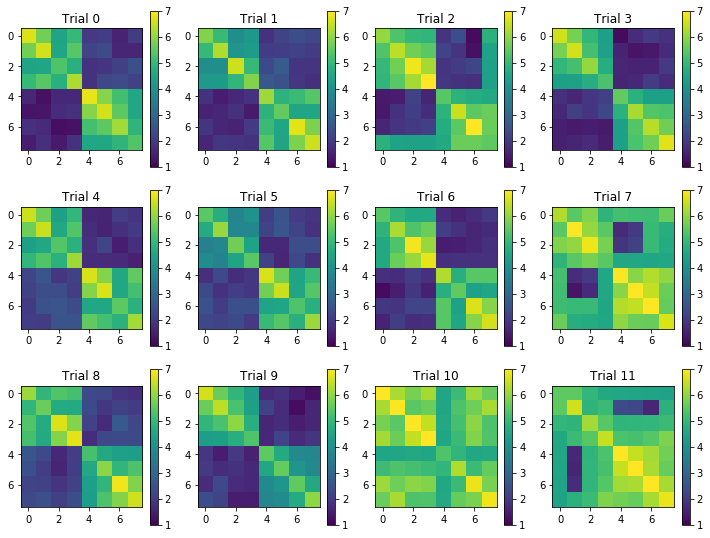

In [33]:
plt.figure(figsize=(10, 10))
dim = np.ceil(np.sqrt(len(Rs)))
for i, R in enumerate(Rs):
    plt.subplot(dim, dim, i + 1)
    plt.imshow(R[-1], vmin=1.0, vmax=7.0)
    plt.colorbar()
    plt.title("Trial " + str(i))
plt.tight_layout()
plt.show()

In [18]:
def predicted_matrix(S, R):
    """Returned matrix of predicted values given the state assignments S
    and the state interaction score matrix R"""
    p_matrix = np.zeros((len(S),len(S)))
    for i, s1 in enumerate(S):
        for j, s2 in enumerate(S):
            p_matrix[i][j] = R[s1][s2]
    return p_matrix

(5401, 5401)


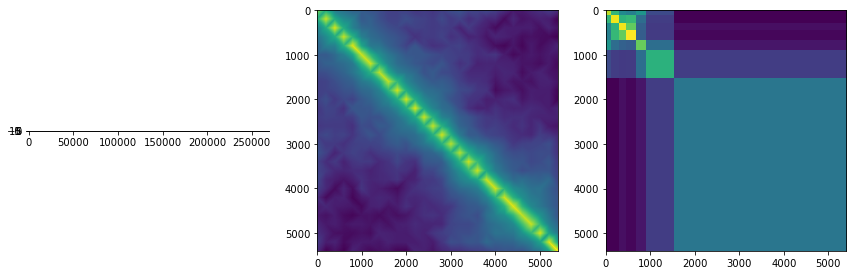

(1801, 1801)


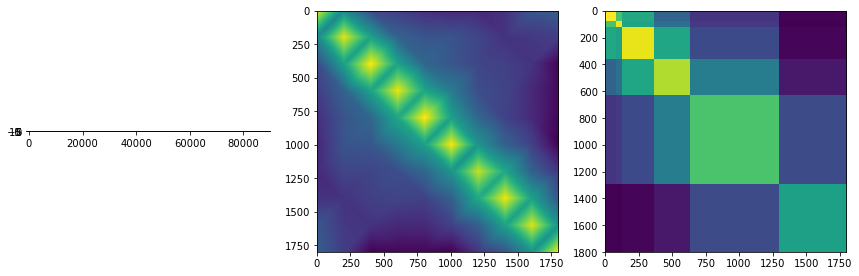

(2001, 2001)


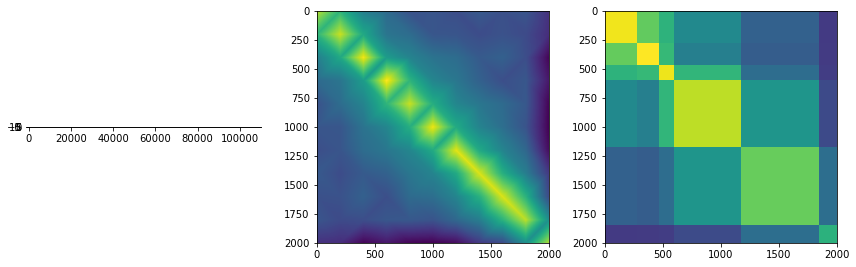

(4201, 4201)


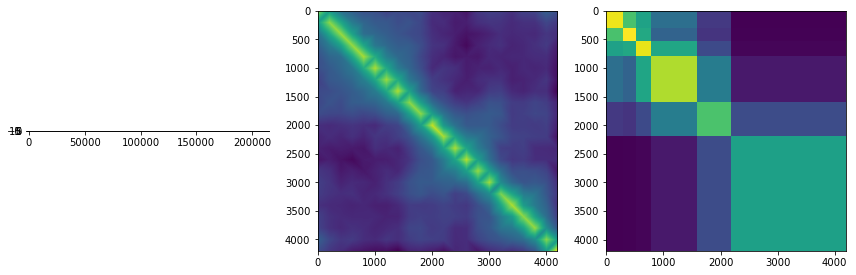

(3201, 3201)


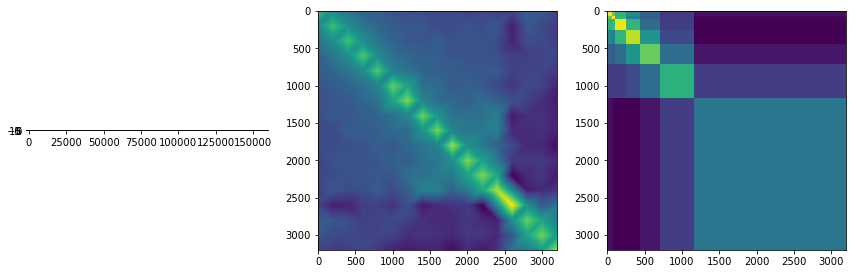

(1601, 1601)


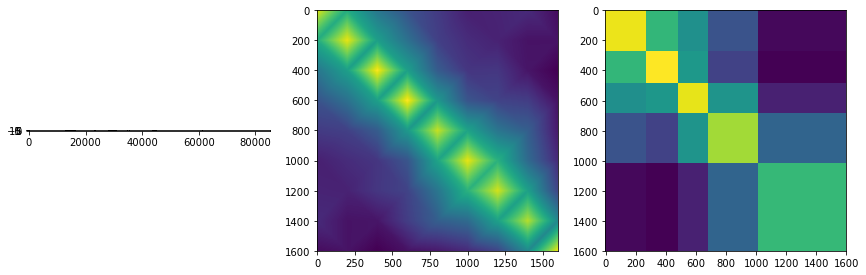

(2001, 2001)


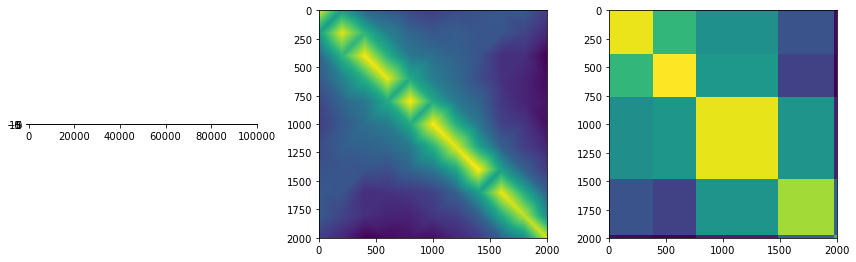

(1601, 1601)


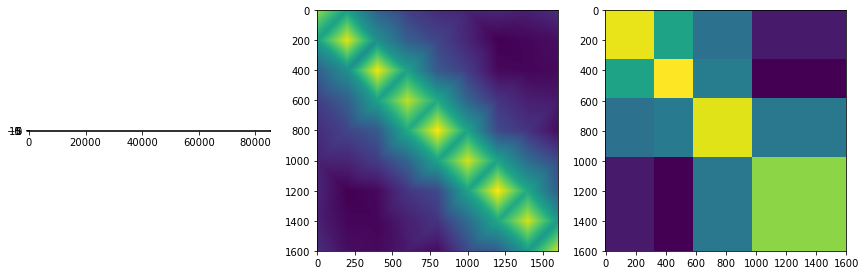

(2801, 2801)


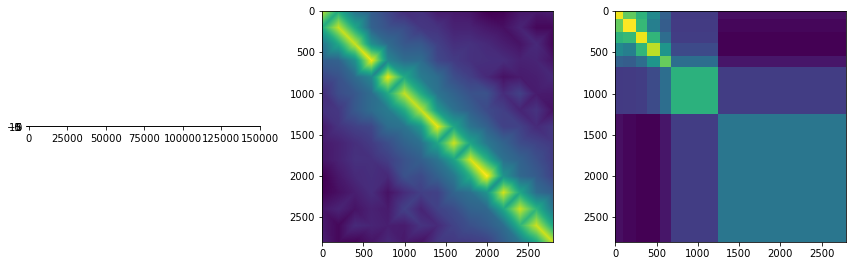

(1801, 1801)


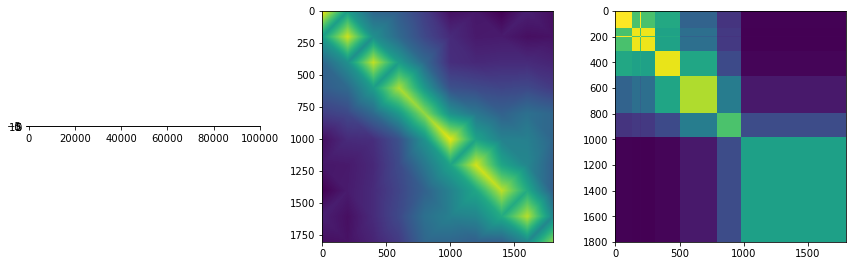

In [21]:
for seq, mat in batch:
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(seq.to_array(), cmap='Greys')
    plt.subplot(1, 3, 2)
    grid = mat.values_grid(spacing)
    print(grid.shape)
    plt.imshow(grid)
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_matrix(state_map[mat.identifier], Rs[-1]))
    plt.tight_layout()
    plt.show()